# LSTM with Explainability using an attention layer

In this notebook introduces a prediction using a Long Short-Term Memory (LSTM) with explainability. 

The data set used is "Power consumption of Tetouan city Data Set" from UCI Machine Learning Repository.

Also a prediction using XGBoost a different explanatory framework named SHAP was used to compare the LSTM with explainability.


## Libraries

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow import keras
from keras import Model
from keras.layers import Layer

In [3]:
from keras.layers.core import Dense, Reshape, Permute

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBRegressor

In [5]:
import shap

In [6]:
seed = 9
keras.utils.set_random_seed(seed)
np.random.seed(seed)

## Data Processing

In [7]:
data = pd.read_csv('Tetuan_City_power_consumption.csv',delimiter=',')
n = len(data)
data.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [8]:
data.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

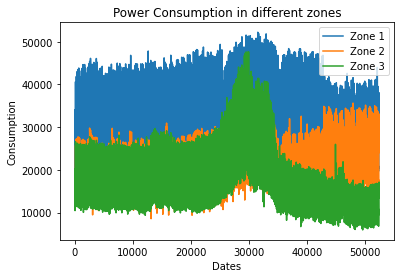

In [9]:
x = range(n)
plt.plot(x,data['Zone 1 Power Consumption'], label="Zone 1")
plt.plot(x,data['Zone 2  Power Consumption'], label="Zone 2")
plt.plot(x,data['Zone 3  Power Consumption'], label="Zone 3")
plt.title("Power Consumption in different zones")
plt.xlabel("Dates")
plt.ylabel("Consumption")
plt.legend()

In [10]:
norma_df = lambda data: (data - data.min()) / (data.max() - data.min())

## Training

In this section we perform the prediction using LSTM and XGBoost of the variable 'Zone 1 Power Consumption'.

### Data pre-processing

In [11]:
y = data['Zone 1 Power Consumption']
X = data[['Temperature', 'Humidity', 'Wind Speed','general diffuse flows', 'diffuse flows']]

Splitting into Train and Test dataset

In [12]:
y_training, y_testing = y[3:int(n*0.75)].reset_index(drop=True), y[int(n*0.75)+3:n].reset_index(drop=True)
X_training, X_testing = X[0:int(n*0.75)].reset_index(drop=True), X[int(n*0.75):n].reset_index(drop=True)

Normalization

In [13]:
X_training, X_testing = norma_df(X_training), norma_df(X_testing)

### LSTM

In [14]:
def add_lags(dataset):
    mt = []
    for i in range(3, len(dataset)):
        a = [dataset['Temperature'][i - 3], dataset['Temperature'][i - 2], dataset['Temperature'][i - 1], 
             dataset['Temperature'][i]]
        b = [dataset['Humidity'][i - 3], dataset['Humidity'][i - 2], dataset['Humidity'][i - 1], dataset['Humidity'][i]]
        c = [dataset['Wind Speed'][i - 3], dataset['Wind Speed'][i - 2], dataset['Wind Speed'][i - 1], 
             dataset['Wind Speed'][i]]
        d = [dataset['general diffuse flows'][i - 3], dataset['general diffuse flows'][i - 2], dataset['general diffuse flows'][i - 1],
             dataset['general diffuse flows'][i]]
        e = [dataset['diffuse flows'][i - 3], dataset['diffuse flows'][i - 2], dataset['diffuse flows'][i - 1],
             dataset['diffuse flows'][i]]
        mt.append([a, b, c, d, e])
    return np.array(mt)
    

Adding lag variables to add into the LSTM model

In [15]:
X_training_lags, X_testing_lags = add_lags(X_training), add_lags(X_testing)

The attention layer based in the work of Kaji et al. (2019) and helps to elucidate the weights from the inputs.

In [16]:
def attention_layer(inputs, steps):
    x = Permute((2, 1))(inputs)
    x = Reshape((int(inputs.shape[2]), steps))(x)
    x = Dense(steps, activation='softmax')(x)
    a = Permute((2, 1), name='attention_layer')(x)
    return keras.layers.multiply([inputs, a])

LSTM model to predict the Zone 1 Power Consumption

In [17]:
epochs_n = 1000
batch_size_n = 64

In [18]:
inputs_x = keras.layers.Input(shape=(5, 4))

x = attention_layer(inputs_x, 5)
x = keras.layers.Masking(mask_value=0, input_shape=(5, 4))(x)
x = keras.layers.LSTM(64, return_sequences=False, return_state=False, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
out_model = keras.layers.Dense(1, activation="relu")(x)

model = keras.Model(inputs=inputs_x, outputs=[out_model])
model.compile(loss='mse', optimizer='adam')
model.fit(X_training_lags,y_training, epochs = epochs_n, batch_size = batch_size_n)

Epoch 1/1000
615/615 [==============================] - 7s 8ms/step - loss: 236956112.0000
Epoch 2/1000
615/615 [==============================] - 4s 7ms/step - loss: 47111768.0000
Epoch 3/1000
615/615 [==============================] - 3s 5ms/step - loss: 45404364.0000
Epoch 4/1000
615/615 [==============================] - 4s 6ms/step - loss: 44290872.0000
Epoch 5/1000
615/615 [==============================] - 4s 6ms/step - loss: 43190684.0000
Epoch 6/1000
615/615 [==============================] - 3s 5ms/step - loss: 42500020.0000
Epoch 7/1000
615/615 [==============================] - 3s 5ms/step - loss: 42216260.0000
Epoch 8/1000
615/615 [==============================] - 3s 5ms/step - loss: 41737120.0000
Epoch 9/1000
615/615 [==============================] - 3s 5ms/step - loss: 41270976.0000
Epoch 10/1000
615/615 [==============================] - 3s 5ms/step - loss: 41019500.0000
Epoch 11/1000
615/615 [==============================] - 3s 5ms/step - loss: 40935108.0000
Epoch 1

615/615 [==============================] - 3s 5ms/step - loss: 32828400.0000
Epoch 92/1000
615/615 [==============================] - 4s 6ms/step - loss: 32917648.0000
Epoch 93/1000
615/615 [==============================] - 4s 7ms/step - loss: 32858960.0000
Epoch 94/1000
615/615 [==============================] - 3s 6ms/step - loss: 32844948.0000
Epoch 95/1000
615/615 [==============================] - 4s 7ms/step - loss: 32765900.0000
Epoch 96/1000
615/615 [==============================] - 4s 7ms/step - loss: 32830244.0000
Epoch 97/1000
615/615 [==============================] - 4s 6ms/step - loss: 32764006.0000
Epoch 98/1000
615/615 [==============================] - 4s 6ms/step - loss: 32900182.0000
Epoch 99/1000
615/615 [==============================] - 4s 7ms/step - loss: 32713970.0000
Epoch 100/1000
615/615 [==============================] - 4s 7ms/step - loss: 32798226.0000
Epoch 101/1000
615/615 [==============================] - 5s 8ms/step - loss: 32738078.0000
Epoch 102/1

615/615 [==============================] - 4s 6ms/step - loss: 31913140.0000
Epoch 181/1000
615/615 [==============================] - 3s 5ms/step - loss: 31830266.0000
Epoch 182/1000
615/615 [==============================] - 3s 5ms/step - loss: 31915174.0000
Epoch 183/1000
615/615 [==============================] - 4s 6ms/step - loss: 31785822.0000
Epoch 184/1000
615/615 [==============================] - 4s 6ms/step - loss: 31761944.0000
Epoch 185/1000
615/615 [==============================] - 5s 8ms/step - loss: 31808370.0000
Epoch 186/1000
615/615 [==============================] - 5s 9ms/step - loss: 31710248.0000
Epoch 187/1000
615/615 [==============================] - 4s 6ms/step - loss: 31710018.0000
Epoch 188/1000
615/615 [==============================] - 4s 6ms/step - loss: 31744958.0000
Epoch 189/1000
615/615 [==============================] - 3s 6ms/step - loss: 31804284.0000
Epoch 190/1000
615/615 [==============================] - 3s 6ms/step - loss: 31742938.0000
Epo

615/615 [==============================] - 3s 5ms/step - loss: 31954546.0000
Epoch 270/1000
615/615 [==============================] - 3s 5ms/step - loss: 31019946.0000
Epoch 271/1000
615/615 [==============================] - 3s 5ms/step - loss: 30797992.0000
Epoch 272/1000
615/615 [==============================] - 3s 5ms/step - loss: 30559256.0000
Epoch 273/1000
615/615 [==============================] - 3s 5ms/step - loss: 30526452.0000
Epoch 274/1000
615/615 [==============================] - 4s 6ms/step - loss: 30407104.0000
Epoch 275/1000
615/615 [==============================] - 3s 5ms/step - loss: 30458710.0000
Epoch 276/1000
615/615 [==============================] - 3s 5ms/step - loss: 30368134.0000
Epoch 277/1000
615/615 [==============================] - 3s 5ms/step - loss: 30369372.0000
Epoch 278/1000
615/615 [==============================] - 3s 5ms/step - loss: 30160924.0000
Epoch 279/1000
615/615 [==============================] - 3s 5ms/step - loss: 30168364.0000
Epo

615/615 [==============================] - 3s 6ms/step - loss: 29230134.0000
Epoch 359/1000
615/615 [==============================] - 4s 6ms/step - loss: 29220266.0000
Epoch 360/1000
615/615 [==============================] - 3s 6ms/step - loss: 29137246.0000
Epoch 361/1000
615/615 [==============================] - 3s 6ms/step - loss: 29161928.0000
Epoch 362/1000
615/615 [==============================] - 4s 6ms/step - loss: 29164332.0000
Epoch 363/1000
615/615 [==============================] - 3s 6ms/step - loss: 29199436.0000
Epoch 364/1000
615/615 [==============================] - 4s 7ms/step - loss: 29175246.0000
Epoch 365/1000
615/615 [==============================] - 4s 6ms/step - loss: 29212420.0000
Epoch 366/1000
615/615 [==============================] - 3s 6ms/step - loss: 29077690.0000
Epoch 367/1000
615/615 [==============================] - 4s 6ms/step - loss: 29066534.0000
Epoch 368/1000
615/615 [==============================] - 4s 6ms/step - loss: 29118558.0000
Epo

615/615 [==============================] - 4s 7ms/step - loss: 27967684.0000
Epoch 448/1000
615/615 [==============================] - 5s 8ms/step - loss: 27906628.0000
Epoch 449/1000
615/615 [==============================] - 4s 6ms/step - loss: 27946576.0000
Epoch 450/1000
615/615 [==============================] - 3s 5ms/step - loss: 27925286.0000
Epoch 451/1000
615/615 [==============================] - 4s 6ms/step - loss: 27818970.0000
Epoch 452/1000
615/615 [==============================] - 4s 6ms/step - loss: 27851604.0000
Epoch 453/1000
615/615 [==============================] - 4s 7ms/step - loss: 27832006.0000
Epoch 454/1000
615/615 [==============================] - 4s 7ms/step - loss: 27943602.0000
Epoch 455/1000
615/615 [==============================] - 4s 7ms/step - loss: 27849732.0000
Epoch 456/1000
615/615 [==============================] - 5s 9ms/step - loss: 27902690.0000
Epoch 457/1000
615/615 [==============================] - 4s 6ms/step - loss: 27867732.0000
Epo

615/615 [==============================] - 4s 7ms/step - loss: 27333618.0000
Epoch 537/1000
615/615 [==============================] - 3s 5ms/step - loss: 27381514.0000
Epoch 538/1000
615/615 [==============================] - 3s 5ms/step - loss: 27361646.0000
Epoch 539/1000
615/615 [==============================] - 3s 5ms/step - loss: 27325402.0000
Epoch 540/1000
615/615 [==============================] - 3s 5ms/step - loss: 27222996.0000
Epoch 541/1000
615/615 [==============================] - 3s 5ms/step - loss: 27471132.0000
Epoch 542/1000
615/615 [==============================] - 3s 4ms/step - loss: 27296880.0000
Epoch 543/1000
615/615 [==============================] - 3s 4ms/step - loss: 27329232.0000
Epoch 544/1000
615/615 [==============================] - 3s 4ms/step - loss: 27287074.0000
Epoch 545/1000
615/615 [==============================] - 3s 4ms/step - loss: 27345340.0000
Epoch 546/1000
615/615 [==============================] - 3s 5ms/step - loss: 27213080.0000
Epo

615/615 [==============================] - 4s 7ms/step - loss: 26728200.0000
Epoch 626/1000
615/615 [==============================] - 4s 7ms/step - loss: 26788528.0000
Epoch 627/1000
615/615 [==============================] - 6s 10ms/step - loss: 26756316.0000
Epoch 628/1000
615/615 [==============================] - 4s 7ms/step - loss: 26827796.0000
Epoch 629/1000
615/615 [==============================] - 4s 6ms/step - loss: 26818362.0000
Epoch 630/1000
615/615 [==============================] - 4s 6ms/step - loss: 26763430.0000
Epoch 631/1000
615/615 [==============================] - 4s 6ms/step - loss: 26864710.0000
Epoch 632/1000
615/615 [==============================] - 4s 6ms/step - loss: 26859518.0000
Epoch 633/1000
615/615 [==============================] - 4s 6ms/step - loss: 26767180.0000
Epoch 634/1000
615/615 [==============================] - 4s 6ms/step - loss: 26707898.0000
Epoch 635/1000
615/615 [==============================] - 4s 6ms/step - loss: 26649440.0000
Ep

615/615 [==============================] - 4s 6ms/step - loss: 26204972.0000
Epoch 715/1000
615/615 [==============================] - 4s 6ms/step - loss: 26153030.0000
Epoch 716/1000
615/615 [==============================] - 4s 7ms/step - loss: 26214302.0000
Epoch 717/1000
615/615 [==============================] - 5s 7ms/step - loss: 26194718.0000
Epoch 718/1000
615/615 [==============================] - 5s 8ms/step - loss: 26194702.0000
Epoch 719/1000
615/615 [==============================] - 5s 9ms/step - loss: 26189226.0000
Epoch 720/1000
615/615 [==============================] - 7s 11ms/step - loss: 26160166.0000
Epoch 721/1000
615/615 [==============================] - 6s 10ms/step - loss: 26135608.0000
Epoch 722/1000
615/615 [==============================] - 6s 9ms/step - loss: 26144374.0000
Epoch 723/1000
615/615 [==============================] - 4s 6ms/step - loss: 26182744.0000
Epoch 724/1000
615/615 [==============================] - 4s 7ms/step - loss: 26051432.0000
E

615/615 [==============================] - 5s 8ms/step - loss: 25715876.0000
Epoch 804/1000
615/615 [==============================] - 4s 6ms/step - loss: 25694782.0000
Epoch 805/1000
615/615 [==============================] - 3s 5ms/step - loss: 25758316.0000
Epoch 806/1000
615/615 [==============================] - 3s 5ms/step - loss: 25604404.0000
Epoch 807/1000
615/615 [==============================] - 4s 6ms/step - loss: 25760014.0000
Epoch 808/1000
615/615 [==============================] - 3s 5ms/step - loss: 25725430.0000
Epoch 809/1000
615/615 [==============================] - 3s 6ms/step - loss: 25652676.0000
Epoch 810/1000
615/615 [==============================] - 4s 6ms/step - loss: 25683300.0000
Epoch 811/1000
615/615 [==============================] - 5s 8ms/step - loss: 25669852.0000
Epoch 812/1000
615/615 [==============================] - 4s 7ms/step - loss: 25671898.0000
Epoch 813/1000
615/615 [==============================] - 5s 8ms/step - loss: 25694184.0000
Epo

615/615 [==============================] - 4s 6ms/step - loss: 25326998.0000
Epoch 893/1000
615/615 [==============================] - 3s 6ms/step - loss: 25234382.0000
Epoch 894/1000
615/615 [==============================] - 4s 6ms/step - loss: 25257388.0000
Epoch 895/1000
615/615 [==============================] - 4s 6ms/step - loss: 25267580.0000
Epoch 896/1000
615/615 [==============================] - 4s 6ms/step - loss: 25162892.0000
Epoch 897/1000
615/615 [==============================] - 4s 6ms/step - loss: 25242734.0000
Epoch 898/1000
615/615 [==============================] - 4s 6ms/step - loss: 25145010.0000
Epoch 899/1000
615/615 [==============================] - 4s 6ms/step - loss: 25245500.0000
Epoch 900/1000
615/615 [==============================] - 4s 7ms/step - loss: 25202766.0000
Epoch 901/1000
615/615 [==============================] - 5s 8ms/step - loss: 25183120.0000
Epoch 902/1000
615/615 [==============================] - 4s 7ms/step - loss: 25131198.0000
Epo

615/615 [==============================] - 4s 6ms/step - loss: 24844462.0000
Epoch 982/1000
615/615 [==============================] - 4s 6ms/step - loss: 24774052.0000
Epoch 983/1000
615/615 [==============================] - 4s 6ms/step - loss: 24861926.0000
Epoch 984/1000
615/615 [==============================] - 3s 5ms/step - loss: 24744748.0000
Epoch 985/1000
615/615 [==============================] - 3s 5ms/step - loss: 24814420.0000
Epoch 986/1000
615/615 [==============================] - 4s 6ms/step - loss: 24839200.0000
Epoch 987/1000
615/615 [==============================] - 4s 7ms/step - loss: 24981062.0000
Epoch 988/1000
615/615 [==============================] - 4s 6ms/step - loss: 24686236.0000
Epoch 989/1000
615/615 [==============================] - 4s 6ms/step - loss: 24848670.0000
Epoch 990/1000
615/615 [==============================] - 4s 6ms/step - loss: 24763992.0000
Epoch 991/1000
615/615 [==============================] - 5s 8ms/step - loss: 24894390.0000
Epo

Prediction from the LSTM model

In [19]:
y_pred = model.predict(X_testing_lags)
y_pred = np.squeeze(y_pred)

410/410 [==============================] - 3s 3ms/step


Plot the predicted values

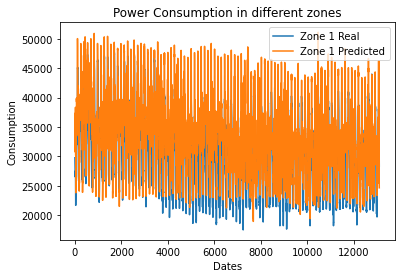

In [20]:
x = range(len(y_testing))
plt.plot(x,y_testing, label="Zone 1 Real")
plt.plot(x,y_pred, label="Zone 1 Predicted")
plt.title("Power Consumption in different zones")
plt.xlabel("Dates")
plt.ylabel("Consumption")
plt.legend()

### XGBoost

Randomized Search of hyperparameters for the XGBoost algorithm.

In [21]:
number_of_iterations = 1000

In [22]:
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [7,10,15],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [5,10,25,50],
              "reg_alpha"   : [0.25,0.5,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}

XGBoost_model_pre = XGBRegressor(random_state=seed)

In [23]:
XGBoost_model_CV = RandomizedSearchCV(XGBoost_model_pre, parameters, cv=5, n_iter=number_of_iterations, 
                                      scoring='neg_mean_absolute_error',verbose=5, n_jobs=-1)

In [24]:
XGBoost_model_CV.fit(X_training[3:], y_training)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.8, 0.9, 1

Call again with the best parameters to use with the SHAP library

In [25]:
XGBoost_model = XGBRegressor(**XGBoost_model_CV.best_params_)
XGBoost_model.fit(X_training[3:], y_training)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=25, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=2, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
y_pred_xg = XGBoost_model.predict(X_testing[3:])

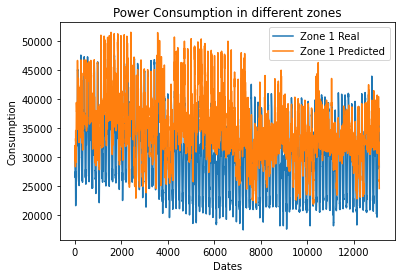

In [27]:
x = range(len(y_testing))
plt.plot(x,y_testing, label="Zone 1 Real")
plt.plot(x,y_pred_xg, label="Zone 1 Predicted")
plt.title("Power Consumption in different zones")
plt.xlabel("Dates")
plt.ylabel("Consumption")
plt.legend()

### Mean Squared Error

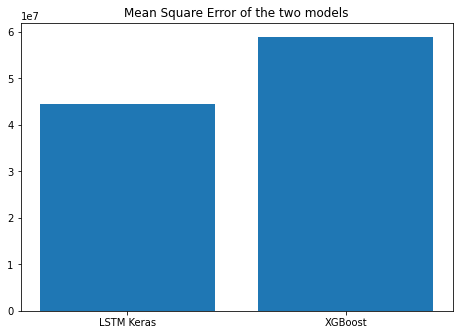

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title('Mean Square Error of the two models')
langs = ['LSTM Keras', 'XGBoost']
students = [mean_squared_error(y_testing, y_pred), mean_squared_error(y_testing, y_pred_xg)]
ax.bar(langs,students)
plt.show()

## Explainability

In this section we develop the explainability of two algortihms. For the LSTM we use the attention layer and to compare we use SHAP with the XGBoost.

### LSTM

Using a layer of attention between the input and the LSTM layer it is possible to obtain a degree of explanations. The attention values are a vector of real values that sums one.

In [29]:
model_output = model.get_layer("attention_layer").output
partial_extraction = Model(inputs = model.input, outputs=model_output)
attention_values = np.array(partial_extraction(X_testing_lags))

We obtain the partial values from the attention model and collect the corresponding to the actual observation and we do not consider the lagged values (t-1, t-2, t-3)

In [30]:
t = []
for i in range(0,len(X_testing),90):
    q = attention_values[i][:,3:4]
    q = np.squeeze(q)
    t.append(q)
t = np.array(t).T

Once the attention values are filtered, we can present them in a heatmap and see the evolution on time.

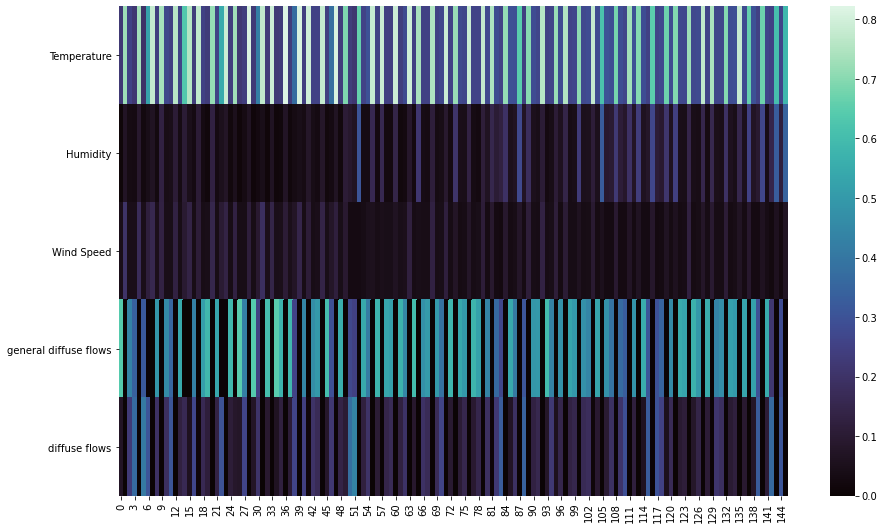

In [31]:
f, ax = plt.subplots(figsize=(15, 9))
y_axis_labels = ['Temperature', 'Humidity', 'Wind Speed','general diffuse flows', 'diffuse flows'] # labels for y-axis
sns.heatmap(t, yticklabels=y_axis_labels, cmap="mako")
plt.show()

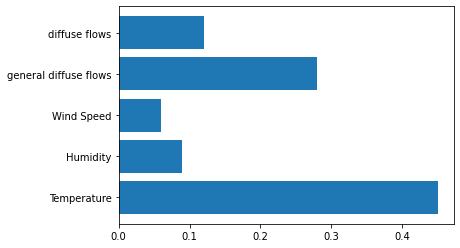

In [32]:
mean_attention_w = [round(np.mean(t[i]),2) for i in range(0,5)]
bars = y_axis_labels
y_pos = np.arange(len(bars))
 

plt.barh(y_pos, mean_attention_w)
plt.yticks(y_pos, bars)
plt.show()

### XGBoost

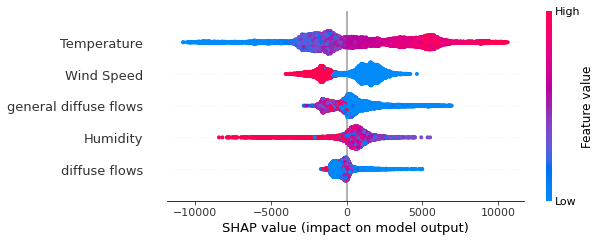

In [33]:
explainer = shap.TreeExplainer(XGBoost_model)
shap_values = explainer.shap_values(X_testing)
shap.summary_plot(shap_values, X_testing)

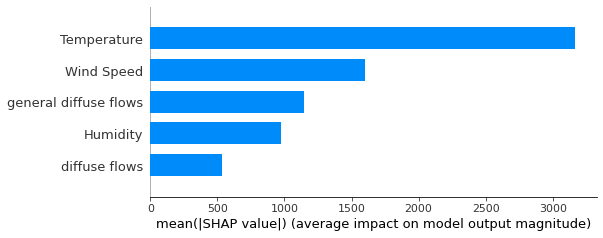

In [34]:
shap.summary_plot(shap_values, X_testing, plot_type="bar")

Both models showed the Temperature as the principal predicting variable.

## References

Kaji, D. A., Zech, J. R., Kim, J. S., Cho, S. K., Dangayach, N. S., Costa, A. B., & Oermann, E. K. (2019). An attention based deep learning model of clinical events in the intensive care unit. PloS one, 14(2), e0211057.

Lundberg, S. M., & Lee, S. I. (2017). A unified approach to interpreting model predictions. Advances in neural information processing systems, 30.

Salam, A., & El Hibaoui, A. (2018, December). Comparison of Machine Learning Algorithms for the Power Consumption Prediction:-Case Study of Tetouan cityâ€“. In 2018 6th International Renewable and Sustainable Energy Conference (IRSEC) (pp. 1-5). IEEE.â€

Data: https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city